In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

In [2]:
import pickle
import boto3
import numpy as np
import pandas as pd
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns

## Importamos la información

In [3]:
session = boto3.session.Session()
s3client = session.client('s3')

In [4]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/features_train.pkl')

body = response['Body'].read()
features_train = pickle.loads(body)

In [5]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/labels_train.pkl')

body = response['Body'].read()
labels_train = pickle.loads(body)

In [6]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/features_test.pkl')

body = response['Body'].read()
features_test = pickle.loads(body)

In [7]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/labels_test.pkl')

body = response['Body'].read()
labels_test = pickle.loads(body)

In [8]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/df.pkl')

body = response['Body'].read()
df = pickle.loads(body)

In [9]:
features_train.shape

(5783, 300)

In [10]:
features_test.shape

(1446, 300)

## Cross-Validation para tuneo de hyperparámetros

In [11]:
svc_0 = svm.SVC(random_state=8)
pprint(svc_0.get_params())

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


**Busqueda aleatoria Cross Validation**

In [12]:
C = [0.0001, 0.001, 0.01]
gamma = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
degree = [1, 2, 3, 4, 5]
kernel = ['linear', 'rbf', 'poly']
probability = [True]
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability}

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [13]:
svc = svm.SVC(random_state=8)

busqueda = RandomizedSearchCV(estimator=svc,
                             param_distributions=random_grid,
                             n_jobs=-1,
                             n_iter=50,
                             scoring='accuracy',
                             cv=3,
                             verbose=1,
                             random_state=8)

busqueda.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 17.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=8, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   pre_dispatch='2*n_jobs', random_s

In [14]:
print(busqueda.best_params_)

{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}


In [15]:
print(busqueda.best_score_)

0.7162372471035795


Acotamos nuestra busqueda considerando los valores encontrados.

**Grid Search Cross Validation**

In [16]:
C = [0.0001, 0.001, 0.01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
    {'C': C, 'kernel':['linear'], 'probability':probability},
    {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
    {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

svc = svm.SVC(random_state=8)

cv_sets = ShuffleSplit(n_splits = 3,
                       test_size = 0.33, 
                       random_state = 8)

grid_search = GridSearchCV(estimator=svc,
                          param_grid=param_grid,
                          n_jobs=-1,
                          scoring='accuracy',
                          cv=cv_sets,
                          verbose=1)

grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  9.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=8, shrinking=True,
                           tol=0.001, verbose=False),
             iid='wa...=-1,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'kernel': ['poly'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rbf'],
                          'probability': [True]}],
             pre_

In [17]:
print(grid_search.best_params_)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf', 'probability': True}


In [18]:
print(grid_search.best_score_)

0.7038589139165357


**Modelo**

In [19]:
best_svc = grid_search.best_estimator_

In [20]:
best_svc

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=8, shrinking=True, tol=0.001, verbose=False)

##  Fit y desempeño del modelo

Modelamos con la data de entrenamiento

In [21]:
best_svc.fit(features_train, labels_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=8, shrinking=True, tol=0.001, verbose=False)

Predicciones

In [22]:
svc_pred = best_svc.predict(features_test)

**training accuracy**

In [23]:
print(accuracy_score(labels_train, best_svc.predict(features_train)))

0.7501296904720733


**test accuracy**

In [24]:
print(accuracy_score(labels_test, svc_pred))

0.6936376210235131


**classification report**

In [25]:
print(classification_report(labels_test, svc_pred))

              precision    recall  f1-score   support

           0       0.61      0.68      0.65       593
           1       0.76      0.70      0.73       853

    accuracy                           0.69      1446
   macro avg       0.69      0.69      0.69      1446
weighted avg       0.70      0.69      0.70      1446



**confusion matrix**

<function matplotlib.pyplot.show(*args, **kw)>

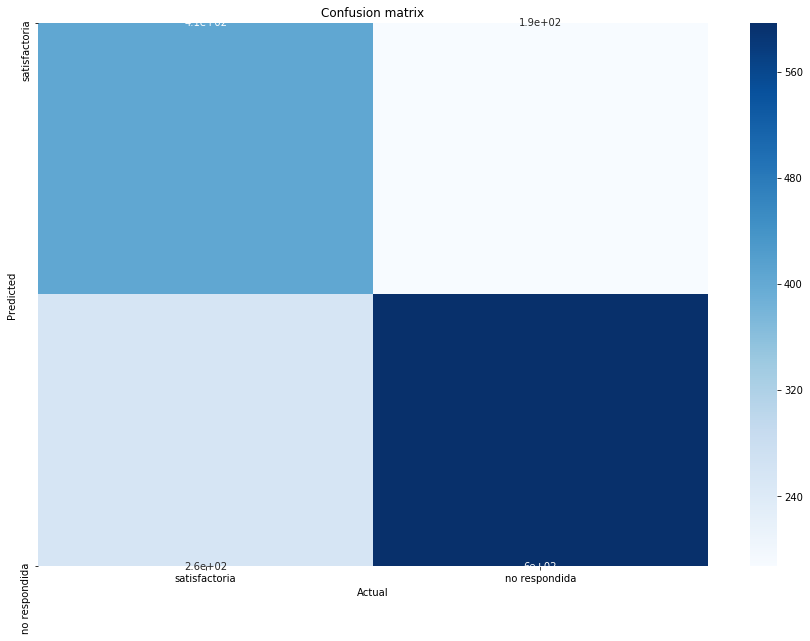

In [33]:
aux_df = df[['calidad_respuesta_real', 'codigo_calidad_respuesta_real']].drop_duplicates().sort_values('codigo_calidad_respuesta_real')
conf_matrix = confusion_matrix(labels_test, svc_pred)
plt.figure(figsize=(15,10))
sns.heatmap(conf_matrix,
           annot=True,
           xticklabels=aux_df['calidad_respuesta_real'].values,
           yticklabels=aux_df['calidad_respuesta_real'].values,
           cmap='Blues')

plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show

Creamos un dataframe

In [28]:
data = {
    'Modelo': 'SVM',
    'Training Set Accuracy': accuracy_score(labels_train, best_svc.predict(features_train)),
    'Test Set Accuracy': accuracy_score(labels_test, svc_pred)
}
df_models_svc = pd.DataFrame(data, index=[0])

In [29]:
df_models_svc

,Modelo,Training Set Accuracy,Test Set Accuracy
0,SVM,0.75013,0.693638


embedings

agregar variable importance plot, investigar si existe algo similar para SVM.

## Guardamos en S3

In [ ]:
bucket='inai-summerofdata'
key='modeling/SVM/0_year_dependencia/best_svc.pkl'
pickle_byte_obj = pickle.dumps(best_svc)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)

In [ ]:
bucket='inai-summerofdata'
key='modeling/SVM/0_year_dependencia/df_models_svc.pkl'
pickle_byte_obj = pickle.dumps(df_models_svc)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)